## Background removal for video using PCA (SVD) to describe the background
This notebook is based on a primary presentation by Rachel Thomas found here: https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb#SVD <br><br>
Here opencv is used for video processing. The present code was developed using Kubuntu 18.04 and Python 3.6 with 32 Mb of RAM. It has also been tested in Windows 10.  

Original video from "BMC 2012 Background Models Challenge Dataset" http://bmc.iut-auvergne.com/?page_id=24 

Alternative location: https://github.com/momonala/image-processing-projects/blob/master/background_removal/video/Video_003/Video_003.avi

In [15]:
import cv2 #This is opencv
import GenPlot as gp
import numpy as np
import sklearn.decomposition
print('Present version of scikit learn', sklearn.__version__)

Present version of scikit learn 0.21.3


In [16]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### Read one frame from the video

In [17]:
cap = cv2.VideoCapture('data/Video_003.avi')

video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
print ("Number of frames: ", video_length)

ret, frame = cap.read()
cap.release()

Number of frames:  794


In [18]:
print(type(frame), frame.shape)

<class 'numpy.ndarray'> (240, 320, 3)


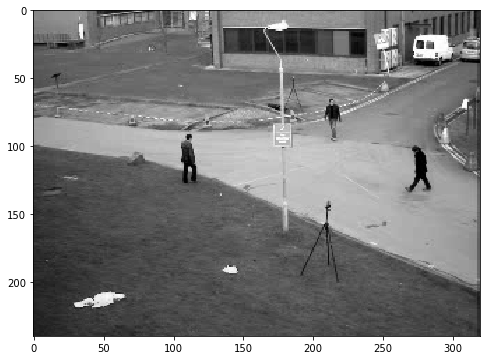

In [19]:
f2 = gp.Figure()
f2.imshow(rgb2gray(frame), cmap='gray')


### Load the video using opencv

In [20]:
all_frames = np.zeros((video_length, frame.shape[0], frame.shape[1], frame.shape[2]), dtype=np.uint8)

In [21]:
cap = cv2.VideoCapture('data/Video_003.avi')
for i in range(video_length):
    is_ok, frame = cap.read()
    if is_ok:
        all_frames[i, :] = frame
    else:
        print('Did not read full video')
        break
    
    

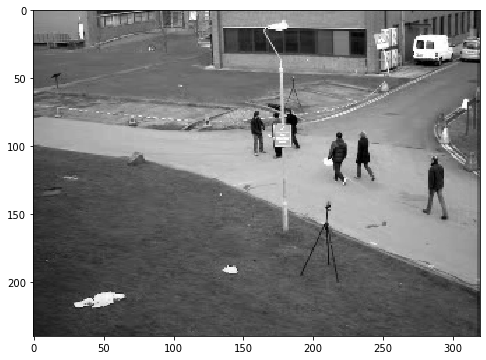

In [22]:
f3 = gp.Figure()
f3.imshow(rgb2gray(all_frames[50]), cmap='gray')

### Show one image frame flattened to a row to be put in a table subjected to principal components analysis


(76800,)


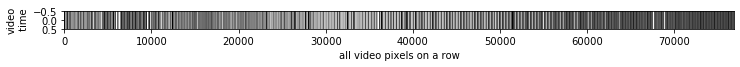

In [23]:
img = rgb2gray(all_frames[50])
flattened_img = np.ravel(img)
print(flattened_img.shape )
f3 = gp.Figure(figsize=(12,9))
f3.imshow(np.atleast_2d(flattened_img), aspect=2000, cmap='gray')
f3.ylabel('video\n time')
f3.xlabel('all video pixels on a row')

### Randomized SVD from the scikit-learn library is good for rapid PCA calculations on large data sets


In [24]:
def PCA_by_randomizedSVD(X, components):
    trace = True
    U, S, V = sklearn.decomposition.randomized_svd(X, components)        
    T = U*S
    P = V
    if trace:
        print()
        print('SVD U S shapes', U.shape, S.shape )
        print('PCA T.shape', T.shape)
        print('PCA P.shape', P.shape)
    return T, P, S

In [35]:
all_BW_frames = rgb2gray(all_frames)
print('Dimensions of the video frames:', all_BW_frames.shape, type(all_BW_frames), type(all_BW_frames[0,0,0]))

Dimensions of the video frames: (794, 240, 320) <class 'numpy.ndarray'> <class 'numpy.float64'>


In [37]:
all_BW_rows = np.reshape(all_BW_frames, (-1, 240*320))
print('Dimensions of the flattened video frames:', all_BW_rows.shape)

Dimensions of the flattened video frames: (794, 76800)


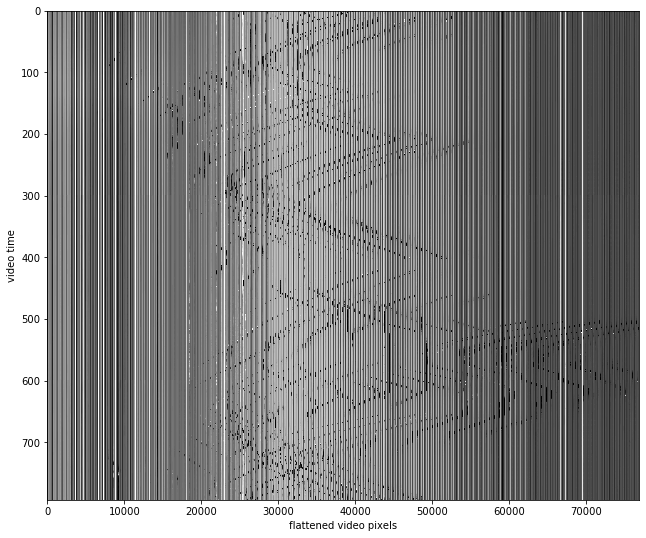

In [38]:
f4 = gp.Figure(figsize=(12,9))
f4.imshow(all_BW_rows, aspect=80.0, cmap='gray')
f4.ylabel('video time')
f4.xlabel('flattened video pixels')

In [39]:
%%time
T, P, S = PCA_by_randomizedSVD(all_BW_rows, 6)


SVD U S shapes (794, 6) (6,)
PCA T.shape (794, 6)
PCA P.shape (6, 76800)
Wall time: 952 ms


### Amount of variation modelled by component

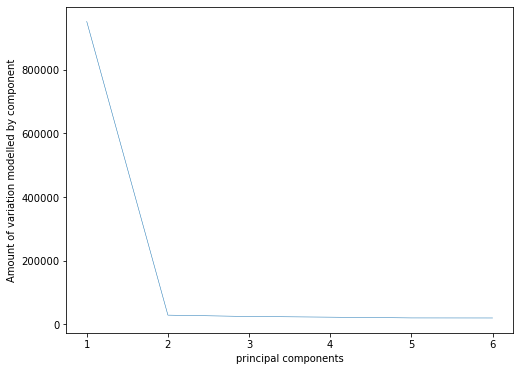

In [40]:
f4b = gp.Figure()
f4b.plot(np.arange(6)+1, S)
f4b.xlabel('principal components')
f4b.ylabel('Amount of variation modelled by component')

In [41]:
one_comp_reconstruction = np.outer(T[:,0], P[0,:])

print('Size of reconstruction:', one_comp_reconstruction.shape, one_comp_reconstruction.size )

Size of reconstruction: (794, 76800) 60979200


### Flattened video pixels of background reconstruction from component 1

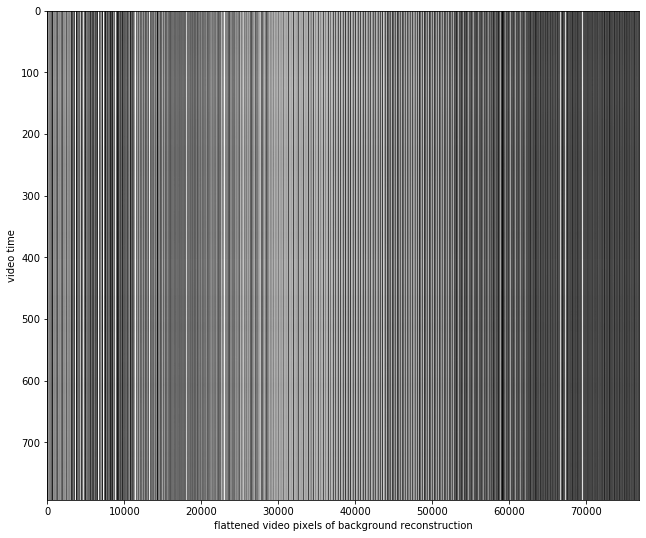

In [43]:
f5 = gp.Figure(figsize=(12,9))
f5.imshow(one_comp_reconstruction, aspect=80.0, cmap='gray')
f5.ylabel('video time')
f5.xlabel('flattened video pixels of background reconstruction')

### Variation in component 1 score values

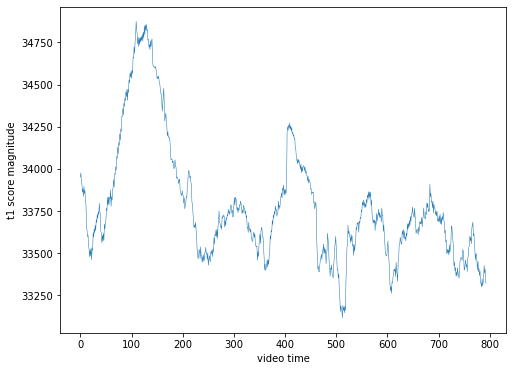

In [44]:
f4c = gp.Figure()
f4c.plot( T[:,0])
f4c.xlabel('video time')
f4c.ylabel('t1 score magnitude')

### Background reconstruction for frame 45 of the video

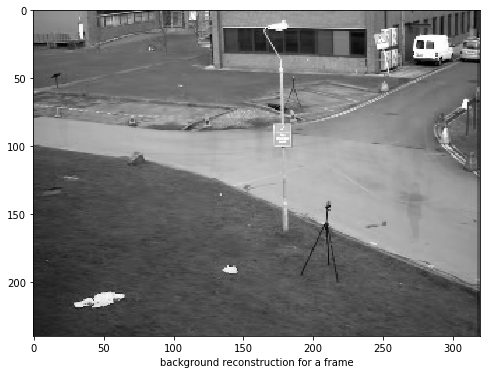

In [45]:
nr = 45
f6 = gp.Figure()
f6.imshow(np.reshape(one_comp_reconstruction[nr,:], (240, 320)), cmap='gray')
f6.xlabel('background reconstruction for a frame')

### Video frame after subtraction of its individual background reconstruction

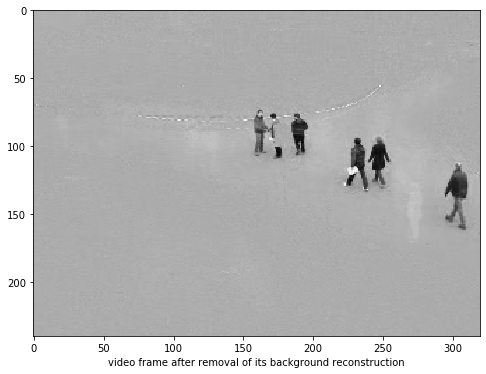

In [46]:
f7 = gp.Figure()
f7.imshow(np.reshape(all_BW_rows[nr,:]-one_comp_reconstruction[nr,:], (240, 320)), cmap='gray')
f7.xlabel('video frame after removal of its background reconstruction')

### Reconstruct video

In [48]:
flat_imgs = all_BW_rows - one_comp_reconstruction
flat_imgs_min = np.min(flat_imgs)
flat_imgs_max = np.max(flat_imgs)
print('flat_imgs_min, flat_imgs_max', flat_imgs_min, flat_imgs_max)

#Normalize to integer range 0-255
scaled_flat_imgs = np.asarray(255*(flat_imgs - flat_imgs_min)/(flat_imgs_max - flat_imgs_min), dtype=np.uint8)

flat_imgs_min, flat_imgs_max -238.26067456775644 195.18729257709245


In [49]:
def transform_BW_image_to_3_layer_format(img):
    img_3layer = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for layer in range(3):
        img_3layer[:,:,layer] = img
    return img_3layer

In [50]:
frame_size = (frame.shape[1], frame.shape[0]) # size = (width, height)
out = cv2.VideoWriter('Reconstr05.mp4',cv2.VideoWriter_fourcc(*'X264'), 7, frame_size)
for i in range(len(scaled_flat_imgs)):
    img = np.reshape(scaled_flat_imgs[i], (frame.shape[0], frame.shape[1]))
    out.write(transform_BW_image_to_3_layer_format(img))
out.release()

In [51]:
from IPython.display import Video
Video('Reconstr05.mp4')

### References
Videoprocessing library: opencv, https://opencv.org/ <br>
Machine learning library: Sci-kit learn, https://scikit-learn.org/stable/index.html provided randomized_svd <br>
The originating source for this example: https://www.fast.ai/ and https://github.com/fastai/numerical-linear-algebra/blob/master/README.md
        
### Future possibilities
1, Now the whole video is kept in memory. Rewrite the reconstruction of the video to work from videoframes stored on file using the HDF5 file format with the h5py library.
<br><br>
2, Then test to remove the background of a higher resolution video
<br><br>

/Mats Josefson 2019-10-19